# CTM MILP Model Running Environment

**NOTE:** When about to make a new run, please **duplicate** this notebook then add necessary graphs and things below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *

# Add more CTM models here as needed
from ctmmodels.ringbarrier import DTSimplexRingBarrier as NewModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* Default parameters used before:

{

    time_range = 30
    time_ticks = np.arange(0, time_range+1, 1)

    parameters = {
        'r_left': 1.0/3.0,
        'r_through': 1.0/3.0,
        'r_right': 1.0/3.0,
        'sat_flow_rate': 1800,
        'time_range': time_range,
        'time_step': 2,
        'g_min': 6,
        'g_max': 20
    }

}

* Saturation flow rate was set to 1800 vphpl, as this was the closest realistic value that matched the calculations from the parent paper.

* Traffic will be distributed evenly between the 4 lanes (left, through 1, through 2, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

# Varying parameters: demand, alpha, beta, gamma

In [4]:
def run_model(demand, weights=(0.33, 0.33, 0.33), new_model=True, log_output=True):
    if new_model:
        model = NewModel(
            demand=demand,
            alpha=weights[0],
            beta=weights[1],
            gamma=weights[2],
            **parameters
        )
    else:
        model = OldModel(
            demand=demand,
            **parameters
        )

    model.generate()
    runtime = model.solve(log_output=log_output)
    return model, runtime

In [5]:
model, runtime = run_model(900)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 3172 rows and 292 columns.
MIP Presolve modified 692 coefficients.
Aggregator did 142 substitutions.
Reduced MIP has 3488 rows, 1906 columns, and 11472 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.07 ticks)
Found incumbent of value 1122.770214 after 0.03 sec. (23.20 ticks)
Probing fixed 0 vars, tightened 104 bounds.
Probing time = 0.00 sec. (0.55 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2796 rows, 1714 columns, and 9972 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.20 ticks)
Probing time = 0.00 sec. (1.18 ticks)
Tried aggregator 1 time.
Reduced MIP has 2796 rows, 1714 columns, and 9972 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Pr

In [7]:
vol = model.return_volume()
vol

[44.0, 46.0, 44.0, 46.0]

In [8]:
dfx, dfy, dfg = model.return_solution()

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [9]:
_approach = SOUTHBOUND

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [21]:
def plot_volume(dfx, cell_path=_cell_path, title="Volume", headless=False, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [20]:
def plot_flow(dfy, cell_path, title, headless=False, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [12]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

In [13]:
def plot_greentime_nophase(dfg):
    df_g_map = dfg.pivot(index='timestep', columns='cell', values='is_green')
    approaches = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

    _, axs = plt.subplots(4,3,figsize=(20,20), sharey=True)

    for i in range(4):
        for j in range(3):
             sns.lineplot(data=df_g_map[[approaches[i][j]]], ax=axs[i][j])

## Generating graphs for each model case

In [14]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [15]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [16]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## Checking the parent model

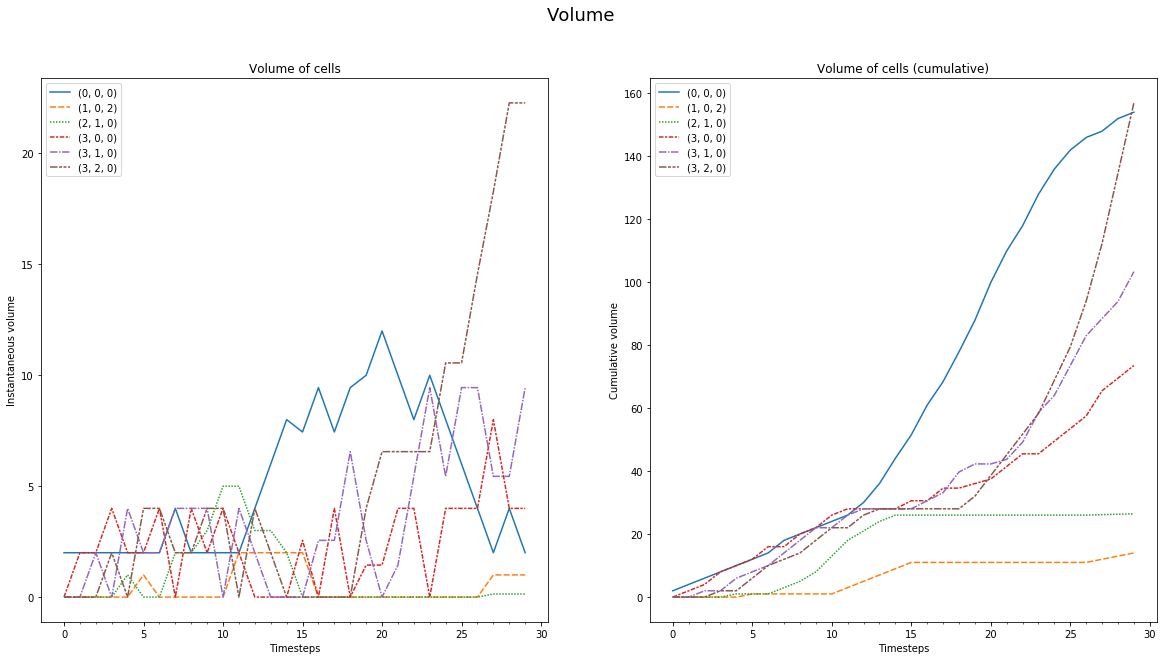

In [22]:
plot_volume(dfx)

## 1. Checking the effect of flow weight

**VERDICT:** Inconclusive, but cursory examination of graphs reveal a flow weight of 0.6

**Notes:**
* For alpha = 1, objective function values dont vary with flow weight
* For alpha = 0, delay values vary between 1350 and 1450; throughput values don't
* Runtime graphs are erratic
* Flow diagrams are more or less erratic, some flow weights (e.g. 0.4) give more erratic flow diagrams than others

## 2. Checking the effect of traffic demand

### Alpha = 1, Flow weight = 0.6, Demand = [450, 900]

In [19]:
demands = [x for x in range(450, 901, 50)]
demands2 = [x for x in range(950, 1801, 50)]

#runtimes = []
#obj_value_list = []
alpha = 1
flow_weight = 0.6

for d in demands2:
    dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=d, alpha=alpha, use=True, flow_weight=flow_weight)
    runtimes.append(runtime)
    obj_value_list.append(obj_values)
    
    generate_graphs(dfx, dfy, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], d, alpha, flow_weight, folder='demands/')
    print("\n~~~\nDone with {}!\n~~~\n".format(d))

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1940 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 128 substitutions.
Reduced MIP has 3482 rows, 1860 columns, and 12232 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.67 ticks)
Found incumbent of value 3586.978307 after 0.04 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 142 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.55 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


      0     0      686.2478   126      803.4383      Cuts: 22      743   14.59%
*     0+    0                          792.5426      686.2478            13.41%
      0     0      686.2478   119      792.5426   ZeroHalf: 2      749   13.41%
      0     0      686.2478   125      792.5426      Cuts: 35      790   13.41%
*     0+    0                          754.4472      686.2478             9.04%
      0     2      686.2478   120      754.4472      692.4925      790    8.21%
Elapsed time = 1.22 sec. (938.65 ticks, tree = 0.01 MB, solutions = 6)
    238   110      753.5922    73      754.4472      693.7289    16406    8.05%
    540   176      740.9247    75      754.4472      705.3572    33720    6.51%
*   606   203      integral     0      754.2567      705.3572    36964    6.48%
*   733   280      integral     0      752.0011      711.9212    45388    5.33%
*   743   311      integral     0      751.7636      711.9212    50159    5.30%
*   752   310      integral     0      751.5262  

Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.56 ticks)
Probing time = 0.01 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.26 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.18 sec. (193.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         4867.0009    -6109.8310           225.54%
      0     0     1265.4102    84     4867.0009     1265.4102       25   74.00%
*     0+    0                         1502.3398     1265.4102            15.77%
      0     0     126

Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.56 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.26 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.21 sec. (207.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         5228.7562    -6088.4347           216.44%
      0    

  Sync time (average)   =    0.51 sec.
  Wait time (average)   =    0.01 sec.
                          ------------
Total (root+branch&cut) =    3.23 sec. (2215.42 ticks)
Done!
Time elapsed: 4.0106511116

~~~
Done with 1450!
~~~

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1928 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 116 substitutions.
Reduced MIP has 3506 rows, 1872 columns, and 12248 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.64 ticks)
Found incumbent of value 5588.772250 after 0.03 sec. (26.41 ticks)
Probing fixed 0 vars, tightened 140 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2814 rows, 1680 columns, and 10540 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


      0     0     2540.6171   118     2629.7498   Flowcuts: 1      426    3.31%
      0     0     2540.6214   118     2629.7498      Cuts: 19      440    3.31%
*     0+    0                         2610.6466     2542.6835             2.60%
*     0+    0                         2605.6759     2546.6770             2.26%
      0     2     2540.6214   114     2605.6759     2546.6770      440    2.26%
Elapsed time = 1.08 sec. (743.87 ticks, tree = 0.01 MB, solutions = 7)
*   192+   64                         2593.4404     2555.9691             1.44%
    220    87     2571.0298    86     2593.4404     2555.9691    14564    1.44%
*   304+   74                         2585.8059     2564.3364             0.83%
    538   130        cutoff           2585.8059     2568.4930    35063    0.67%
    989   216     2584.8097    30     2585.8059     2576.7943    55086    0.35%
*  1112   240      integral     0     2585.7433     2578.4059    60340    0.28%
*  1304   262      integral     0     2585.5693  

## 3. Checking the effect of alpha on the traffic demand curve

In [13]:
_alphas = [x / 8.0 for x in range(4)]
_alphas2 = [x / 8.0 for x in range(4,8)]
_demands = [x for x in range(450, 1801, 50)]
_flow_weight = 0.6

_df_tuples = []
# (demand, runtime, delay, throughput, alpha, flow_weight)

for _a in _alphas2:
    for _d in _demands:
        dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=_d, alpha=_a, use=True, flow_weight=_flow_weight, log_output=False)
        generate_graphs(None, None, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], _d, _a, _flow_weight, folder='')
        
        _df_tuples.append((_d, runtime, obj_values[0], obj_values[1], _a, _flow_weight))
        
        print("\n~~~\nDone with demand {}, alpha {}!\n~~~\n".format(_d, _a))

Solving...
Done!
Time elapsed: 159.514794111

~~~
Done with demand 450, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 73.3284778595

~~~
Done with demand 500, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 41.8842031956

~~~
Done with demand 550, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 12.2617340088

~~~
Done with demand 600, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 37.1376481056

~~~
Done with demand 650, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 10.9574401379

~~~
Done with demand 700, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 6.2417178154

~~~
Done with demand 750, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 7.54641699791

~~~
Done with demand 800, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 5.51469397545

~~~
Done with demand 850, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 4.80589318275

~~~
Done with demand 900, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 5.39438891411

~~~
Done with demand 950, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 6.

Solving...
Done!
Time elapsed: 4.36917185783

~~~
Done with demand 850, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.4025850296

~~~
Done with demand 900, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 3.83675384521

~~~
Done with demand 950, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.66839981079

~~~
Done with demand 1000, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 6.46450901031

~~~
Done with demand 1050, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.46837186813

~~~
Done with demand 1100, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 5.74216103554

~~~
Done with demand 1150, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.78553795815

~~~
Done with demand 1200, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.83922719955

~~~
Done with demand 1250, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 4.37526392937

~~~
Done with demand 1300, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 3.7662858963

~~~
Done with demand 1350, alpha 0.875!
~~~

Solv

## Varying Alpha (Beta = 0) and Checking Delay and Throughput

In [12]:
def run_varying_alphas(demand=600, log_output=False):
    alphas = [x / 8.0 for x in range(9)]
    _df_tuples = []
    
    for a in alphas:
        dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=demand, alpha=a, use=False, flow_weight=0, log_output=log_output)
        _df_tuples.append((demand, runtime, obj_values[0], obj_values[1], a, 0))
        save_df(dfx, "volumes_d{}_a{}_b0".format(demand, a))
        save_df(dfy, "flows_d{}_a{}_b0".format(demand, a))
        save_df(dfg, "greentimes_d{}_a{}_b0".format(demand, a))
        print("\n~~~\nDone with demand {}, alpha {}!\n~~~\n".format(demand, a))
    
    df = pd.DataFrame(data=_df_tuples,columns=['demand', 'runtime', 'delay', 'throughput', 'alpha', 'flow_weight'])
    save_df(df, "results_vs_alpha_d{}_b0".format(demand))
    return df

In [13]:
for d in range(1450,1801,50):
    run_varying_alphas(d)

Solving...
Done!
Time elapsed: 0.888396978378

~~~
Done with demand 1450, alpha 0.0!
~~~

Solving...
Done!
Time elapsed: 4.82988595963

~~~
Done with demand 1450, alpha 0.125!
~~~

Solving...
Done!
Time elapsed: 3.76939988136

~~~
Done with demand 1450, alpha 0.25!
~~~

Solving...
Done!
Time elapsed: 2.73412108421

~~~
Done with demand 1450, alpha 0.375!
~~~

Solving...
Done!
Time elapsed: 2.97149801254

~~~
Done with demand 1450, alpha 0.5!
~~~

Solving...
Done!
Time elapsed: 3.77615523338

~~~
Done with demand 1450, alpha 0.625!
~~~

Solving...
Done!
Time elapsed: 3.26794600487

~~~
Done with demand 1450, alpha 0.75!
~~~

Solving...
Done!
Time elapsed: 2.99579811096

~~~
Done with demand 1450, alpha 0.875!
~~~

Solving...
Done!
Time elapsed: 2.88417196274

~~~
Done with demand 1450, alpha 1.0!
~~~

Solving...
Done!
Time elapsed: 0.612238883972

~~~
Done with demand 1500, alpha 0.0!
~~~

Solving...
Done!
Time elapsed: 4.24946713448

~~~
Done with demand 1500, alpha 0.125!
~~~

Solving

In [22]:
df_varying_alpha = pd.concat(dflist)
df_varying_alpha

,demand,runtime,delay,throughput,alpha,flow_weight
0,450,4.113032,1086.886076,44.556962,0.000,0
1,450,97.208230,861.240506,44.556962,0.125,0
2,450,113.829416,861.240506,44.556962,0.250,0
3,450,138.198439,861.240506,44.556962,0.375,0
4,450,149.478604,861.240506,44.556962,0.500,0
5,450,178.735804,861.240506,44.556962,0.625,0
6,450,156.508035,861.240506,44.556962,0.750,0
7,450,166.392350,861.240506,44.556962,0.875,0
8,450,118.227796,861.240506,44.556962,1.000,0
0,500,2.964355,1264.471871,44.556962,0.000,0


In [23]:
save_df(df_varying_alpha, "tmp_1")